In [ ]:
#이미지를 가져오기 위해 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#필요한 라이브러리 임포트
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [ ]:
#gpu에서 연산이 이루어지는지 확인
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cuda Tesla P100-PCIE-16GB


(1333, 2000, 3)


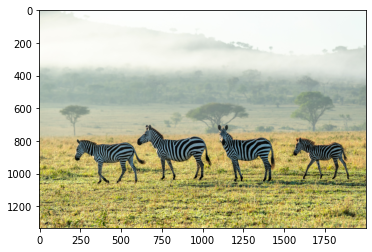

In [ ]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size
# object detection할 이미지, 원본 이미지 크기는 1333 X 2000 X 3 으로 이루어짐.
img0 = cv2.imread("/content/zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [ ]:
#이미지 전처리 단계
# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
# 정답을 만들기 위해 4개의 바운딩 박스를 만듦 0은 back ground 1은 정답 label
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

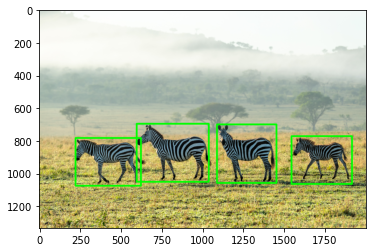

In [ ]:
# display bounding box and labels
# 위에서 만든 바운딩 박스 시각화
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

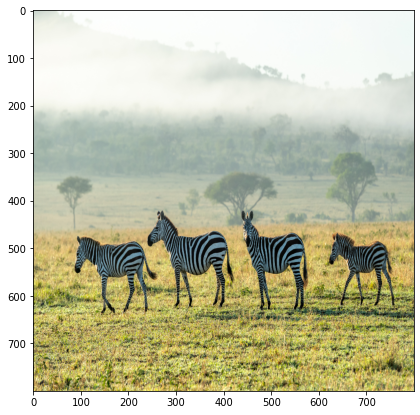

In [ ]:
# resize the input images to h=800, w=800
# 계산의 편이를 위해 이미지를 800 by 800 으로 resize
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
# plt.grid(True, color="black")
plt.show()


0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


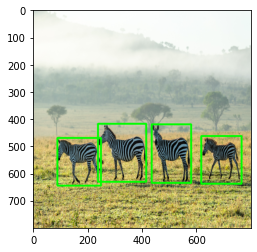

In [ ]:
# change the bounding box coordinates
# original image size : (1333, 2000)
# 바운딩 박스도 축소된 이미지에 맞게 비율을 곱해서 크기를 맞춰줌
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

**Feature extraction by pre-trained VGG16**

pre-trained된 vgg-16을 이용하여 13개의 layer를 가져오고 feature map을 만드는 단계
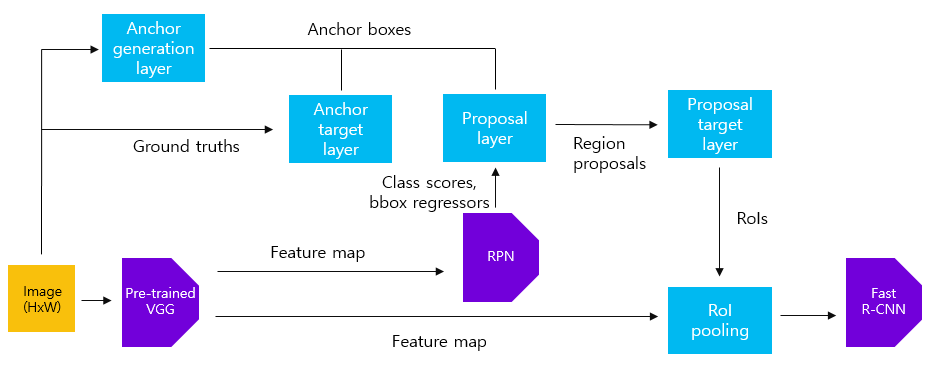

In [ ]:
# only print feature extraction part of VGG16
# pre-trained된 vgg 16모델을 torchvision을 통해 가져옴
model = torchvision.models.vgg16(pretrained=True).to(DEVICE)
features = list(model.features)
print(len(features))
print(features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

논문에서 13개의층 사용한다고 주어져있고 downsampling ratio가 16이므로 14 X 14라고 적힌 부분까지 이용한 것
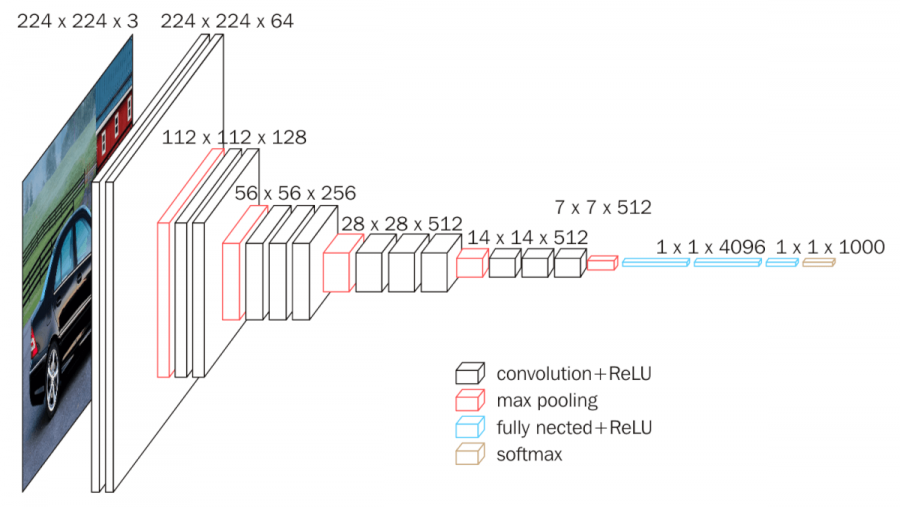

In [ ]:
# only collect layers with output feature map size (W, H) < 50
# 더미 이미지를 만들어서 pre-trained 된 vgg에 넣어서 output 크기를 확인해봄.
# 우리가 사용할 pre-trained-vgg를 50 by 50 크기 까지만 사용할 것이기 때문에 이 까지만 잘라서 faster_rcnn_feature_extractor에 저장해줌.
# downsampling ratio = 16이됨.
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16: # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]
    
print(len(req_features))
# print(req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [ ]:
# convert this list into a Seqeuntial module

faster_rcnn_feature_extractor = nn.Sequential(*req_features)


In [ ]:
# test the results of the input image pass through the feature extractor
# 이미지를 vgg 모델에 넣기 위해 텐서로 만들어줌
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0) 
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

torch.Size([1, 512, 50, 50])


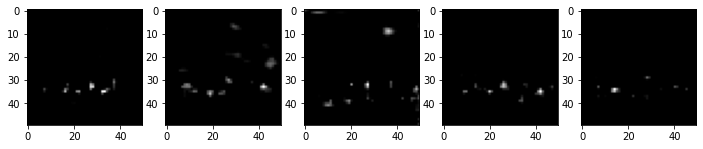

In [ ]:
# visualize the first 5 channels of the 50*50*512 feature maps
# 50 by 50 by 512 의 feature map중 앞에서 5개를 추출하면 아래와 같이 시각화 할 수 있음
imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

**Generate Anchors Boxes**
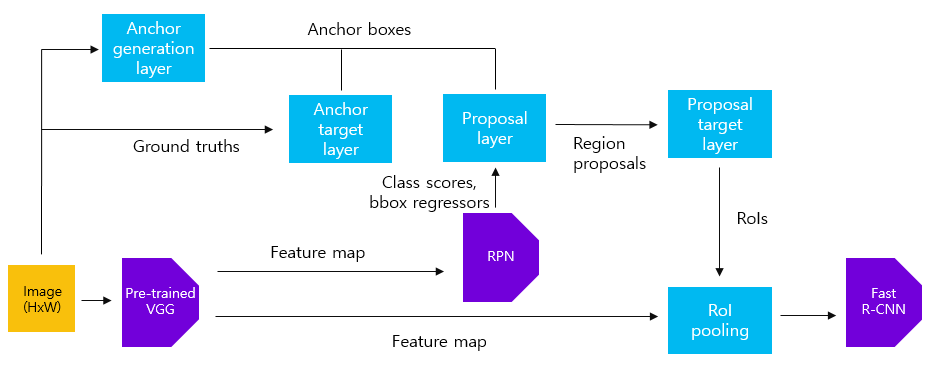

In [ ]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center
# 앵커 박스를 생성 함. 16 X 16 간격의 grid 마다 anchor box를 9개씩 만들어야 하므로 50 X 50 개의 영역이 생긴다.
# 따라서 50 * 50 * 9 = 22500 개의 anchor box를 만들게 된다.
# anchor box를 만들기 위해 먼저 grid를 나눠야 함. center point를 x좌표 50개 y 좌표 50개 만들어줌.
feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [ ]:
# coordinates of the 255 center points to generate anchor boxes
# ctr(x,y)로 좌표를 배정해줌.
index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


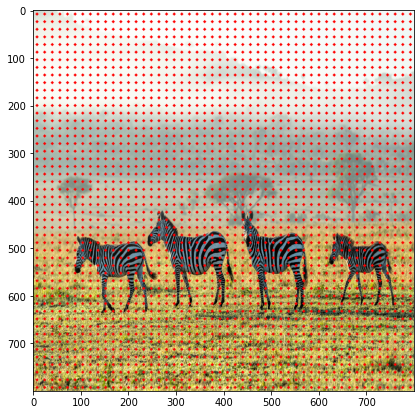

In [ ]:
# display the 2500 anchors within image
# 총 50 X 50개의 앵커 시각화
img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

In [ ]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes
# 3개의 raio, 3개의 scale로 총 9종류의 앵커박스를 앵커별로 만들어줌. 따라서 2500 X 9 = 22500개의 앵커박스가 만들어짐.
# 앵커 박스 변수를 만들어 앵커박스의 (x1, y1, x2, y2) 좌표를 저장 /논문에서 말하는 4개의 좌표(x, y, h, w)와 다름. 
# 후에 IOU를 계산하기 위해서는 영역의 넓이가 필요한데, 이를 위해 이렇게 저장해둔 것.
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
index = 0

for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


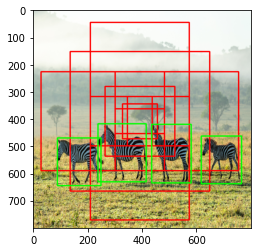

In [ ]:
# display the anchor boxes of one anchor and the ground truth boxes
# 위에서 만든 몇개의 앵커박스와 ground truth 앵커박스를 시각화
img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

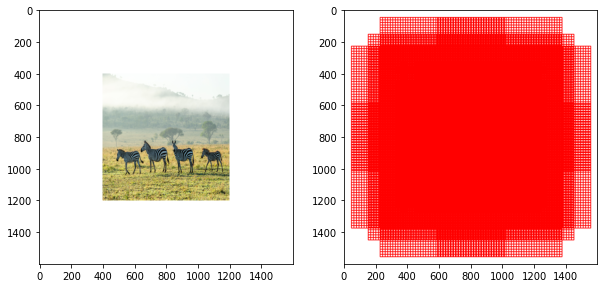

In [ ]:
# draw all anchor boxes
# add paddings(can't draw anchor boxes out of image boundary)
# 전체 앵커박스를 시각화 하면 이미지 사이즈를 벗어나는 앵커박스가 많이 있음.
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

**Anchor Target layer**

학습에 사용할 앵커를 선별하는 과정
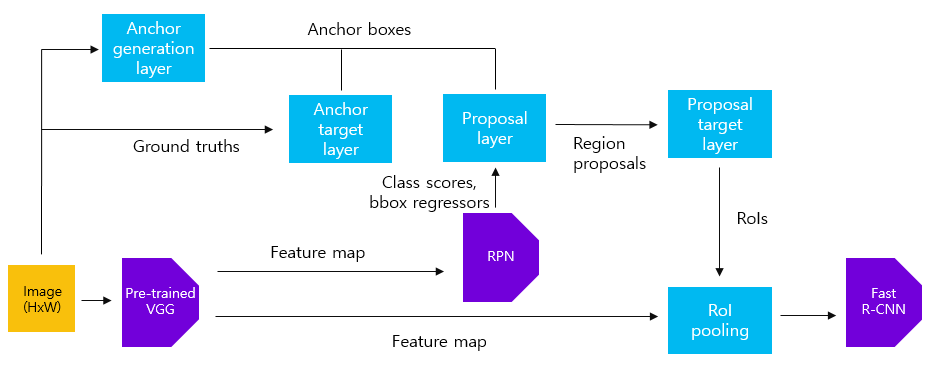

In [ ]:
# RPN을 학습시키기 위해 필요한 앵커박스만 선택하는 작업을 수행. 먼저 이미지 범위 안에 있는 앵커박스만 선택
# 22500 개중 영역안에 있는 박스는 8940개
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800


index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [ ]:
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,
# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]
# 앵커박스에 대하여 ground truth box와 IOU값을 계산
ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


In [ ]:
# what anchor box has max ou with the ground truth box
# ground thuth와 IOU가 가장 큰 anchor box를 구하는 과정. anchor box가 4개 이므로 개의 anchor box가 나옴
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [ ]:
# what ground truth bbox is associated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [ ]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [ ]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3
#IOU를 계산 해서 0.7 이상인 앵커 박스와 ground truth와의 IOU가 가장 큰 anchor box에 대해 positve sample, 0.3이하인 샘플에 대해 negative sample로 저장하고 positive에 대해서는 1, negative에 대해서는 0을 저장

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [ ]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
# pos와 neg를 나눴으면 학습에 사용할 데이터의 미니배치를 구성하게 됨.
# 논문에서 학습에 사용할 앵커박스는 256개(미니 배치 사이즈) 이용한다고 나와있고 이 비율은 각각 0.5
# positve 샘플 128개와 negative 샘플 128개를 랜덤하게 뽑아 각각의 인덱스를 저장
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [ ]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]
# For each valid anchor box, find the groundtruth object which has max_iou 
# 앞서 IOU를 이미 계산했으므로 좌표를 vaild sample에 대해 (x_중심, y_중심, height, width)로 바꿔줌
# 이후 논문에 나오는 loss값에 들어가는 input 형태로 값을 바꿔줌.
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [ ]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


RPN 
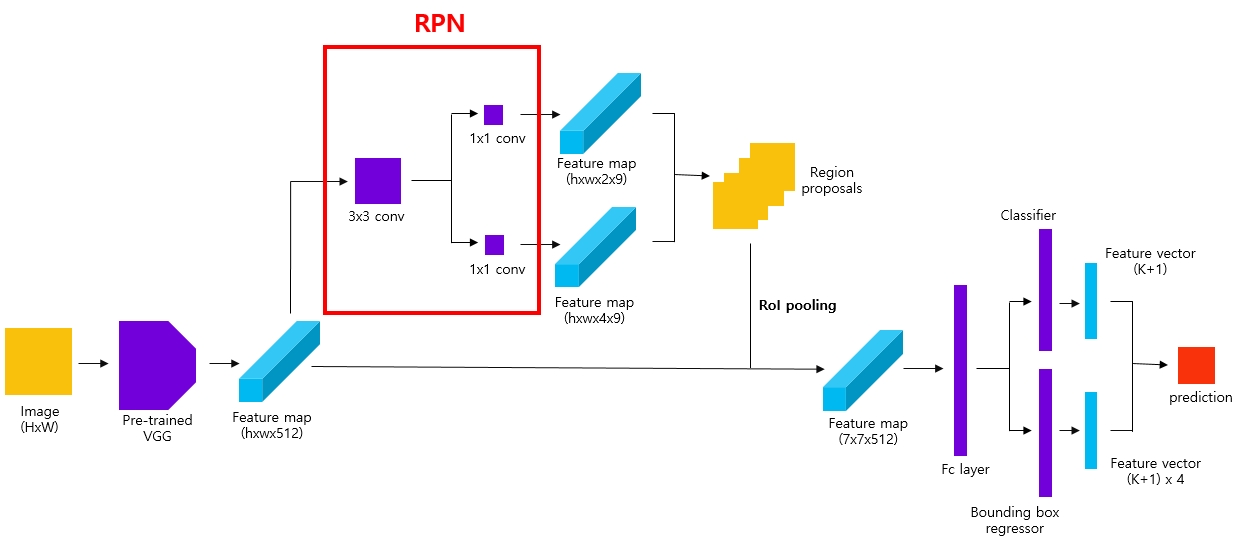

In [ ]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)
# 1 by 1 by (9*2)개의 classification 필터와 1 by 1 (9*4)개의 regressor 필터를 곱해줌
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [ ]:
#실제 이미지를 rpn에 넣어 feature map을 추출해줌
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw) 
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)
# target과 값을 비교하기 이해 resize해줌
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [ ]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [ ]:
# ground truth에 대해 벡터화 시켜줌
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6976, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# only positive samples
# bounding box regressor의 loss 값은 positive 샘플에 대해서만 계산해주기 때문에 masking을 진행
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
# rpn의 regressor loss를 계산해줌
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(15.6798, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.1820, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


**Proposal layer**

여기서 부터는 fast r cnn을 학습하기 위한 단계.Anchor generation layer에서 생성된 anchor boxes와 RPN에서 반환한 class scores와 bounding box regressor를 사용하여 region proposal(물체가 있을 법한 bounding box 2000개)을 추출
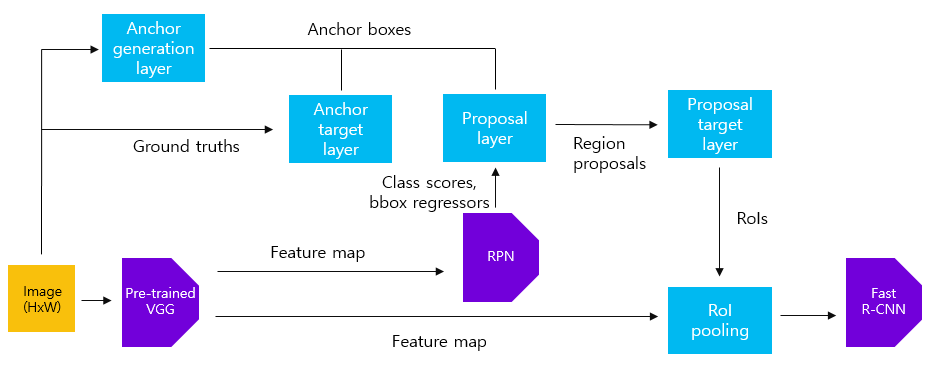

NMS란 Object detector가 예측한 bounding box 중에서 중복을 제거하고 가장 정확한 bounding 박스를 선택하도록 하는 기법.

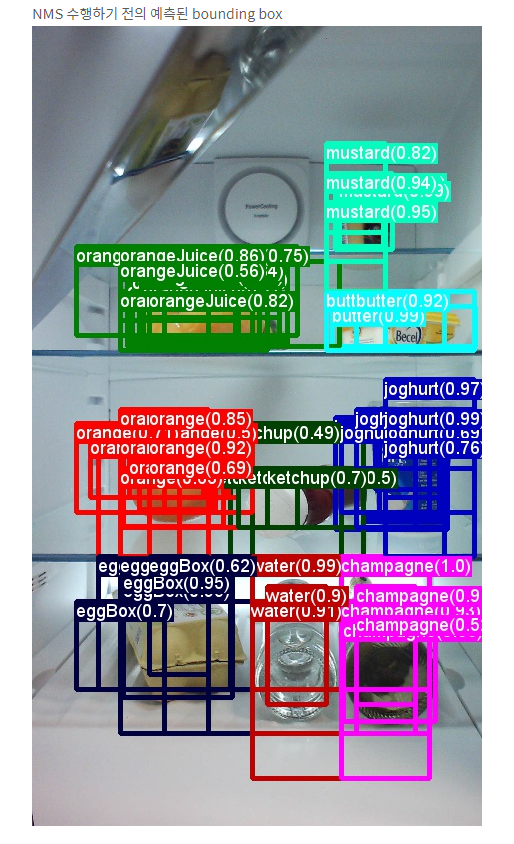
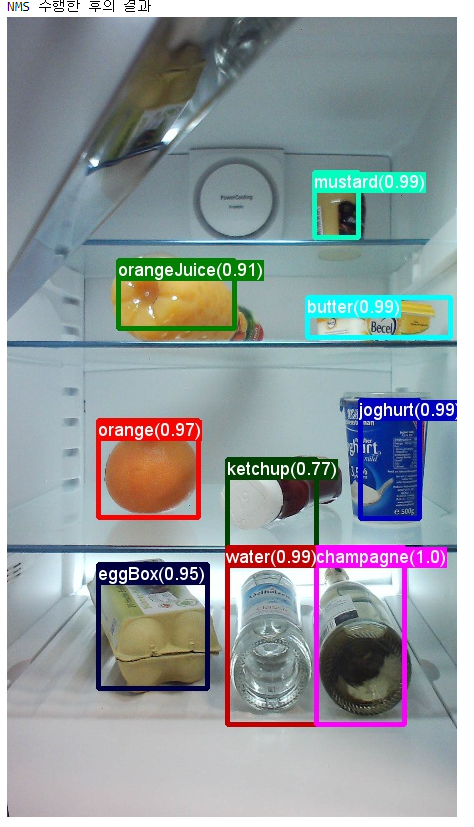

1. convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format.

2. clip the predicted boxes to the image

3. Remove predicted boxes with either height or width < threshold (min_size).

4. Sort all (proposal, score) pairs by score from highest to lowest.

5. Take top pre_nms_topN (e.g. 12000 while training and 300 while testing).

6. Apply nms threshold > 0.7

7. Take top pos_nms_topN (e.g. 2000 while training and 300 while testing)

In [ ]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000
# Proposal layer에서는 Anchor generation layer에서 생성된 anchor boxes와 RPN에서 반환한 class scores와 bounding box regressor를 사용하여
# region proposals를 추출하는 작업을 수행. 
# 먼저 score 변수에 저장된 objectness score를 내림차순으로 정렬한 후 objectness score 상위 N(n_train_pre_nms=12000)개의 anchor box에 대하여 
# Non maximum suppression 알고리즘을 수행. 남은 anchor box 중 상위 N(n_train_post_nms=2000)개의 region proposals를 학습에 사용합니다. 
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [ ]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [ ]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [ ]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [ ]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


In [ ]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [ ]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


In [ ]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [ ]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


In [ ]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


**Proposal Target layer**

 proposal layer에서 나온 region proposals 2000개 중에서 Fast R-CNN 모델을 학습시키기 위한 유용한 sample을 선택하는 과정

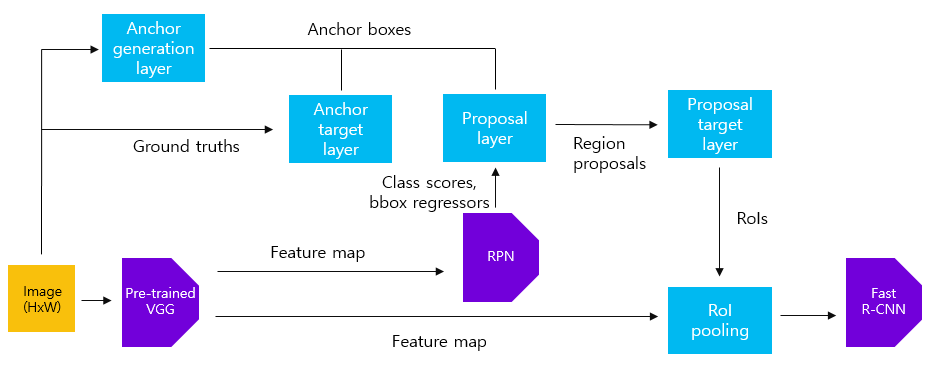

In [ ]:
#region proposals로 추출된 2000개의 sample 중 fast r-cnn을 학습시키기 위한 유용한 샘플을 128개를 선택하는 과정. 2000개 중에 0.5 이상 positive 0.5미만 negative 설정 
# 128 개중에 4분의 1은 pos 4분의 3은 neg로 구성
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [ ]:
# fine the iou of each ground truth object with the region proposals
# 2000개의 샘플(ROI)과 ground truth간의 Iou 계산
ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [ ]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[3 3 3 ... 1 1 1]
[0.02660735 0.2017437  0.049016   ... 0.15623742 0.10772581 0.07773111]
[1 1 1 ... 1 1 1]


In [ ]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

28
[ 294  343  410 1003  293 1657 1202  491 1129 1125 1063 1070 1739 1201
 1780 1073 1267   28 1701  408  345   33 1124 1121  116 1695  406 1126]


In [ ]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

100
[ 885 1697  668  548 1586  306  820  174  257  252  566  135  173  550
  463 1488 1879 1227  697 1345  559   92 1376  190  716 1446 1699 1542
 1245 1891   51 1433   55  792 1748 1918  600  534  811 1969  949  326
 1132 1263 1947  554  359 1834 1332 1421  531  699  713 1402  159    2
 1988  577 1171 1328  403  685 1610  875  989 1377 1514 1412  920  383
  211  424 1303  951 1833  226 1594  880  412   80  115  206 1943 1630
   31   15  335  698 1676 1929 1206  140 1595  856 1869  273 1387 1994
 1110 1074]


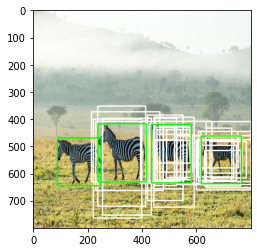

In [ ]:
# display RoI samples with positive

img_clone = np.copy(img)

#positive RoI
for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)

#ground truth
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

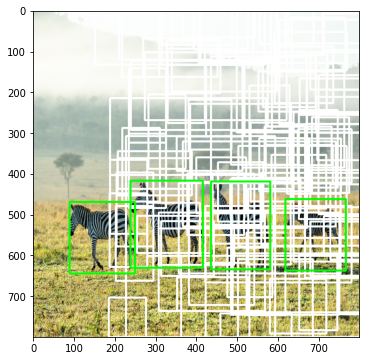

In [ ]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

In [ ]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [ ]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [ ]:
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height

In [ ]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


**RoI pooling **

Feature extractor를 통해 얻은 feature map과 Proposal Target layer에서 추출한 region proposals을 활용하여 RoI pooling을 수행
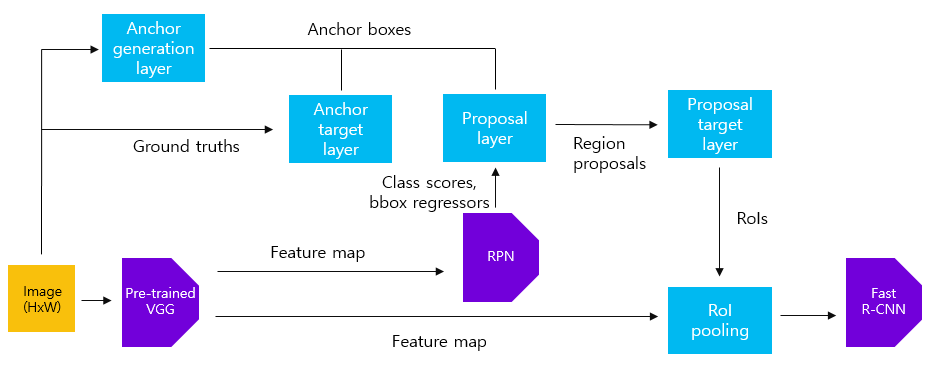

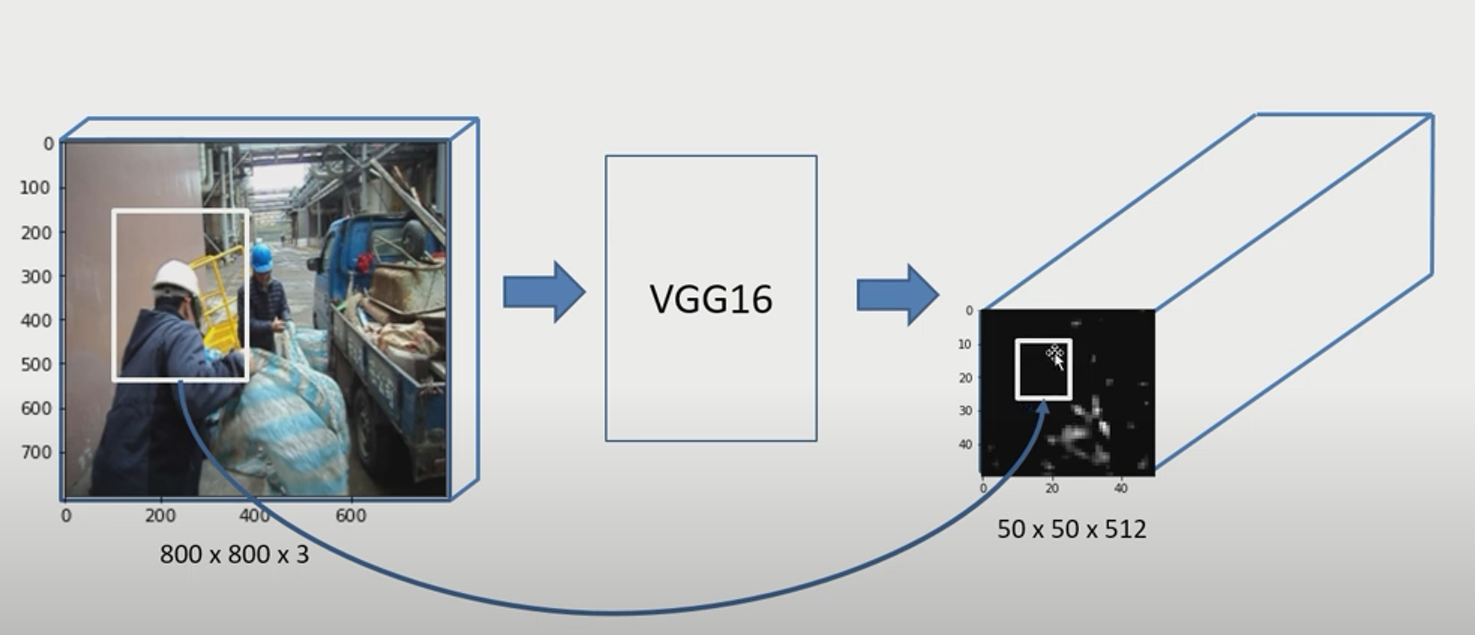

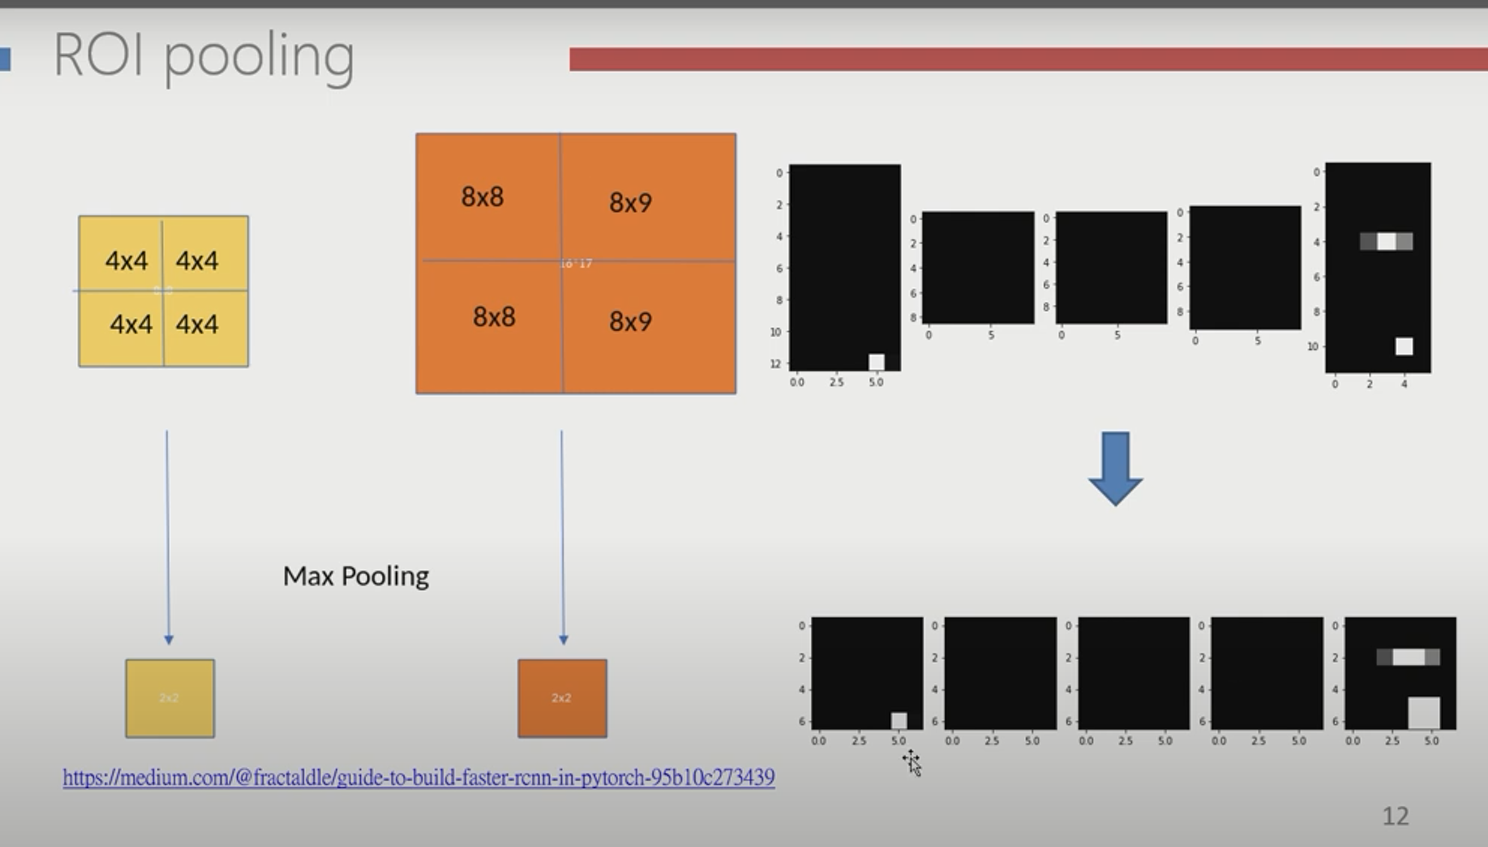

In [ ]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)
# ROI 마다 크기가 다르므로 정사각형 feature map에 넣기 위해서는 크기를 맞춰줘야함.
# max-pooling을 이용해 크기를 맞춰줌

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [ ]:
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


In [ ]:
#
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


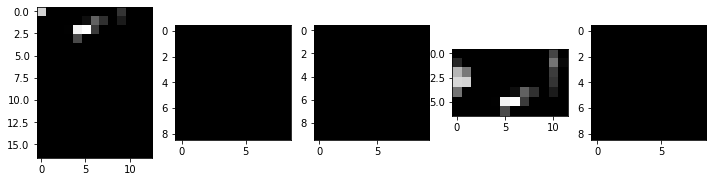

In [ ]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [ ]:
# Reshape the tensor so that we can pass it through the feed forward layer.
# ROI feature vector를 만들기 위해 flatten 해줌.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


**Fast R CNN**
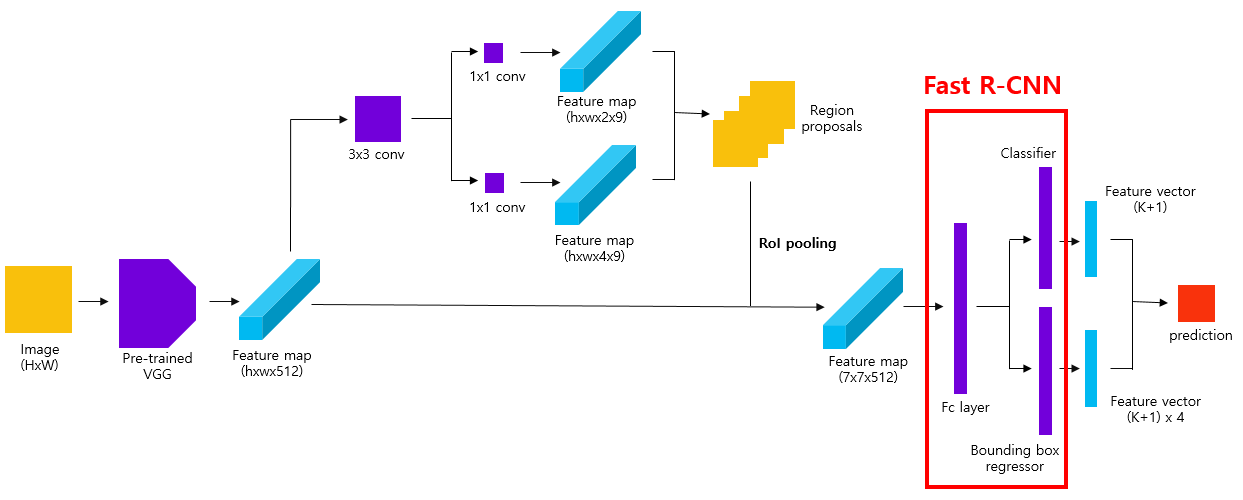

In [ ]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 1 class, 1 background

In [ ]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [ ]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


In [ ]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [ ]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [ ]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [ ]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cuda() - mask_loc_preds.cuda())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([28, 4]) torch.Size([28, 4])
tensor(6.1376, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.6916, 1.1046, 2.4810, 2.2605],
        [0.8576, 1.8263, 0.6888, 1.5872],
        [0.6897, 1.5759, 1.0749, 2.0031],
        [1.8563, 0.6865, 1.3790, 1.2032],
        [1.3085, 0.8173, 0.7087, 4.1999],
        [1.4570, 0.6968, 1.1600, 1.0497],
        [1.1408, 0.6875, 4.7614, 0.6929],
        [0.8206, 1.4259, 0.7188, 3.7796],
        [1.0483, 0.7013, 0.8551, 3.1241],
        [1.0557, 0.9058, 1.4821, 1.9584],
        [0.6915, 2.2613, 0.7925, 1.6196],
        [0.8953, 1.6604, 0.7072, 1.3316],
        [1.0733, 0.7002, 0.8903, 1.1378],
        [0.6865, 0.8750, 1.9059, 1.3274],
        [0.7601, 0.6897, 0.7208, 1.2136],
        [1.4362, 0.9997, 0.9000, 0.7611],
        [0.7889, 0.7113, 1.1755, 1.0197],
        [0.7122, 1.1953, 1.1580, 1.0529],
        [0.8235, 1.4865, 3.5650, 0.7257],
        [0.7129, 0.9057, 1.0548, 0.9344],
        [0.7272, 1.5626, 0.6866, 2.8983],
        [0.7046, 1.6771, 1.3933, 1.3432],
        [0.8301, 1.0164, 0.7093, 1.2353],
        [0.7019, 0.8101, 1.0191, 0